# Algoritmos genéticos (GA)

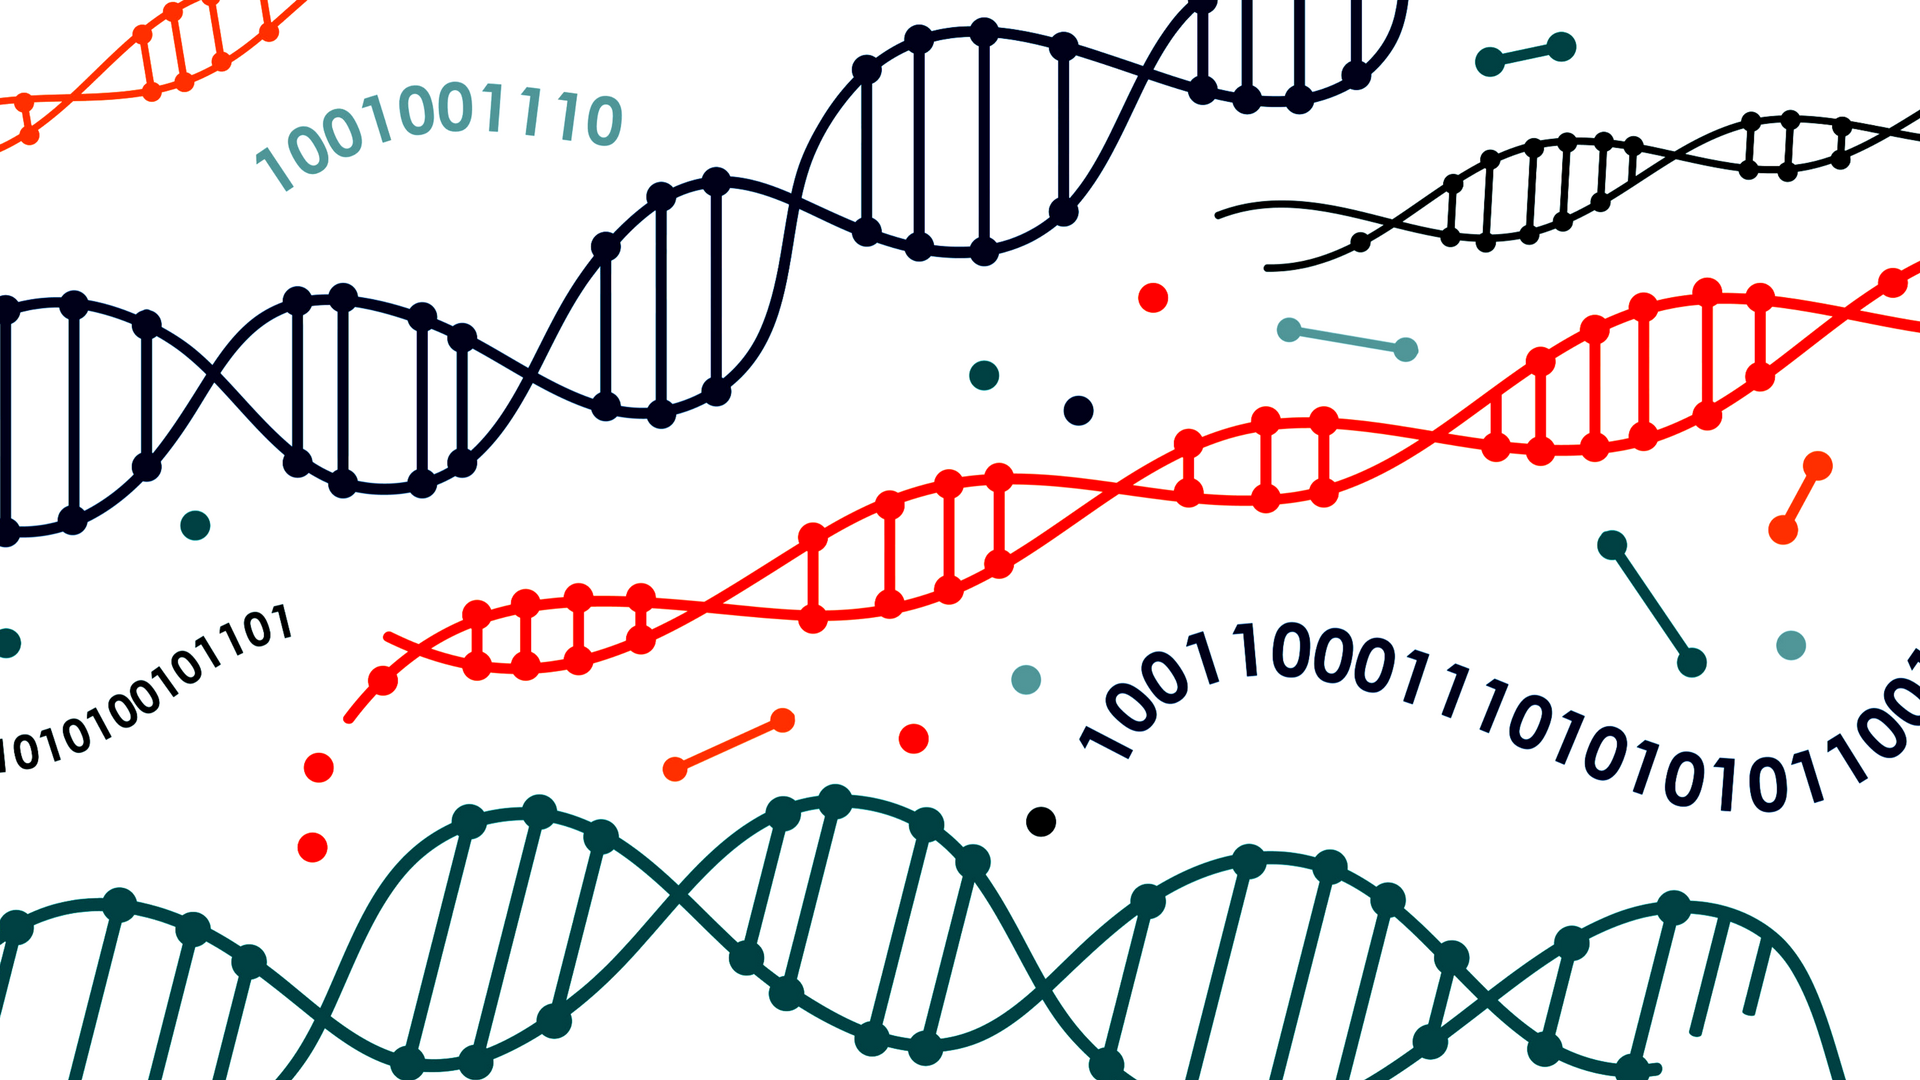

## ¿Qué es un algoritmo genético?

Un algoritmo genético es un método para resolver un problema inspirado en el proceso de [selección natural](https://es.wikipedia.org/wiki/Selecci%C3%B3n_natural) propuesto por Charles Darwin:

> As many more individuals of each species are born than can possibly survive; and as, consequently, there is a frequently recurring struggle for existence, it follows that any being, if it vary however slightly in any manner profitable to itself, under the complex and sometimes varying conditions of life, will have a better chance of surviving, and thus be naturally selected. From the strong principle of inheritance, any selected variety will tend to propagate its new and modified form

Hay muchas variaciones de dichos algoritmos pero todos siguen a grandes rasgos este patrón:

1. Generar una población de individuos (o _cromosomas_ en el léxico de los algoritmos genéticos)

2. Evaluar a los individuos de la población por una métrica de aptitud (conocido como _fitness_)

3. Sólo quedarse con los N sujetos de la población _más aptos_

4. Crear una nueva generación de individuos a partir de los más aptos a través de:
  - cross breeding: "cruza" entre individuos
  - mutations: mutaciones aleatorias
    
    
5. Volver a __paso 2__ y repetir

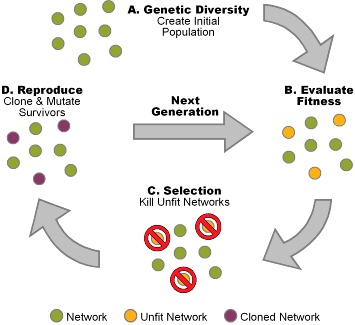

### ¿Qué problemas se pueden resolver?

Los problemas atacados por estos algoritmos son en general de optimización discreta

Los individuos se suelen representar con vectores

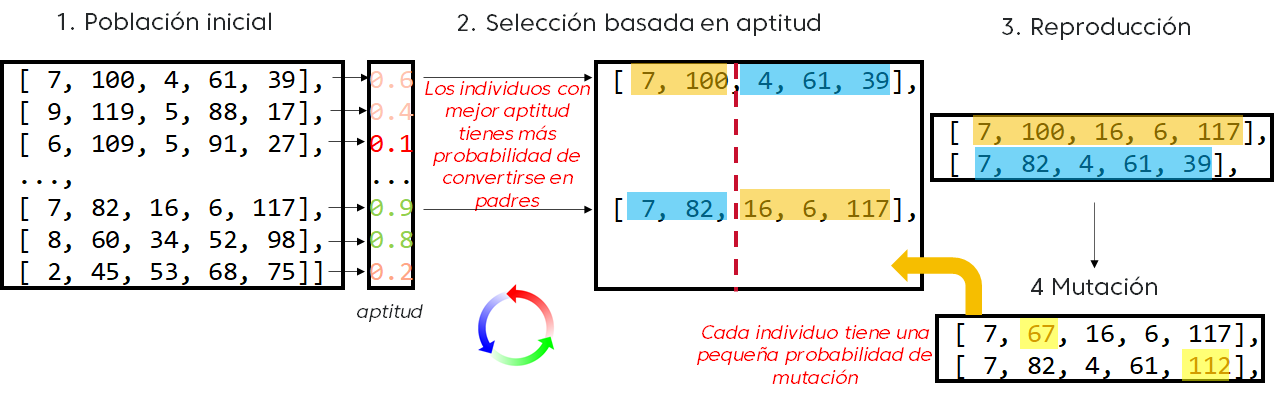

### Ejemplo: Problema de las 8 reinas
El problema de las ocho reinas es un pasatiempo que consiste en poner ocho reinas en el tablero de ajedrez sin que se amenacen.  En el juego del ajedrez la reina amenaza a aquellas piezas que se encuentren en su misma fila, columna o diagonal.

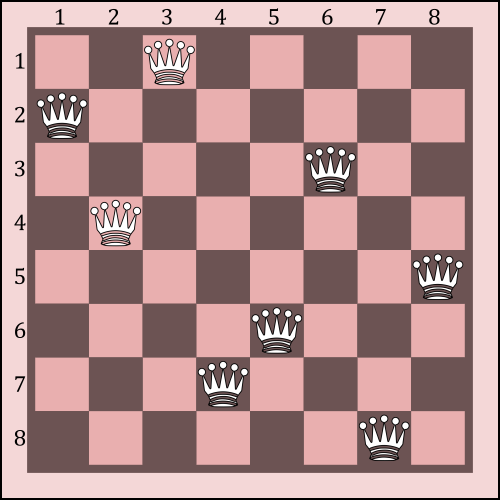

Vamos a utilizar algoritmos genéticos para resolver el problema con un tablero de tamaño $N$

Definimos a cada individuo con un array en función de la posición de cada reina por columnas 

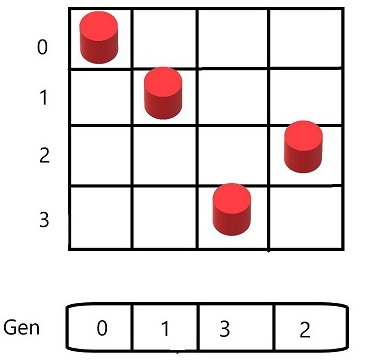

In [1]:
import numpy as np
import random

In [55]:
N = 4

### Representación de los individuos

In [56]:
gen = [0,1,3,2]

In [57]:
def createBoard(n):
    board = [[0 for i in range(n)] for j in range(n)]
    return board

In [58]:
board = createBoard(N)
board

[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

Implementa una función llamada `setBoard`, que introduzca a un individuo en el tablero 

In [59]:
def setBoard(board,gen):
    for i in range(len(gen)):
        board[i][gen[i]]=1
    return board

In [60]:
setBoard(board,gen)

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]

In [61]:
board

[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]

In [62]:
setBoard(createBoard(N),[1,0,2,3])

[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

### Función de aptitud (fitness) 

In [63]:
def fitness(board):
    hits = 0
    for i in range(0,len(board)):
        for j in range(0,len(board)):
            if board[i][j] == 1:
                Vertical = sum([board[i][k] for k in range(0,len(board))]) - 1
                Diagonal1 = sum([board[i-k][j-k] for k in range(1,i+1) if i-k>=0 and j-k>=0])
                Diagonal2 = sum([board[i+k][j+k] for k in range(1,N) if i+k<N and j+k<N])
                Diagonal3 = sum([board[i-k][j+k] for k in range(1,i+1) if i-k<N and j+k<N])
                Diagonal4 = sum([board[i+k][j-k] for k in range(1,N) if i+k<N and j-k<N and i+k>=0 and j-k>=0])
                hits += Vertical + Diagonal1+Diagonal2+Diagonal3+Diagonal4
                #print((i,j),Vertical,Diagonal1,Diagonal2,Diagonal3,Diagonal4)
    return len(board)*(len(board)-1)-hits

In [64]:
board,fitness(board)

([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]], 8)

### 1. Población inicial

In [65]:
def create_starting_population(individuals, chromosome_length):
    population = [np.zeros(chromosome_length).astype(int) for k in range(individuals)]
    L = list(range(chromosome_length))
    for i in range(individuals):
        random.shuffle(L)
        population[i] = L[0:chromosome_length]
    return population

In [66]:
population = create_starting_population(10,N)
population

[[3, 2, 0, 1],
 [1, 2, 3, 0],
 [1, 0, 3, 2],
 [2, 3, 1, 0],
 [2, 3, 0, 1],
 [2, 1, 0, 3],
 [3, 1, 0, 2],
 [0, 1, 3, 2],
 [1, 3, 2, 0],
 [2, 3, 1, 0]]

In [67]:
def calculate_fitness(population):
    pop2 = [setBoard(createBoard(N),gen) for gen in population]
    return [fitness(b) for b in pop2]

In [68]:
scores = calculate_fitness(population)
scores

[8, 4, 4, 8, 4, 4, 10, 8, 10, 8]

### 2. Selección basada en aptitud

In [69]:
def select_individual_by_tournament(population, scores):
    """Select best individuals in the population for the genetic algorithm

    Parameters
    ----------
    population: array
        population to evaluate
    scores: array
        fitness of the individuals

    Returns
    -------
    dictionary
        best two individuals
    """    
    probs = [s/sum(scores) for s in scores]
    population_size = len(scores)
    winners = np.random.choice(np.arange(0,population_size),
                              p=probs,size=population_size,
                              replace=True)
    return {'p1':population[winners[0]], 'p2':population[winners[1]]}

In [70]:
parents = select_individual_by_tournament(population,scores)
parents

{'p1': [3, 1, 0, 2], 'p2': [2, 3, 1, 0]}

### 3. Reproducción

In [71]:
def breed_by_crossover(parent_1, parent_2):
    """Crossover in the genetic algorithm

    Parameters
    ----------
    parent_1: array
        first individual
    parent_2: array
        second individual
        
    Returns
    -------
    array
        two new individuals
    """
    
    chromosome_length=len(parent_1)
    crossover_point = random.randint(1,chromosome_length-1)
    
    child_1 = np.hstack((parent_1[0:crossover_point],
                        parent_2[crossover_point:]))
    child_2 = np.hstack((parent_2[0:crossover_point],
                        parent_1[crossover_point:]))
    
    if len(set(child_1)) != chromosome_length: child_1 = parent_1
    if len(set(child_2)) != chromosome_length: child_2 = parent_2
        
    return child_1, child_2

In [72]:
print(parents)
child_1, child_2 = breed_by_crossover(parents['p1'], parents['p2'])

{'p1': [3, 1, 0, 2], 'p2': [2, 3, 1, 0]}


In [73]:
child_1,child_2

([3, 1, 0, 2], [2, 3, 1, 0])

### 4. Mutación

In [74]:
def mutation(individual,N):
    """Mutation in the genetic algorithm

    Parameters
    ----------
    individual: array
        individual to mutate
    N: integer
        
    Returns
    -------
    array
        individual mutated
    """
    pm = 1/N
    ind0 = individual
    for ind in range(0,N):
        if random.random() < pm:
            individual[ind] = random.randint(0,N-1)
    
    if len(set(individual)) !=N: individual=ind0
    return individual

In [75]:
mutation(child_1,4)

[3, 3, 2, 2]

### Generación a generación
Ahora implementaremos muchas generaciones del algoritmo genético

In [82]:
best_ind = None
best_score = 0

for k in range(3):
    best_score_progress = [] # Tracks progress
    avg_score_progress = []

    maximum_generation = 200
    pop_size = 200
    N=8
    population = create_starting_population(pop_size,N)
    scores = calculate_fitness(population)

    # best_score = np.max(scores)
    # avg_score = np.mean(scores)

    # print ('Starting best score: %.3f' %best_score)

    # Now we'll go through the generations of genetic algorithm
    for generation in range(maximum_generation):
        # Create an empty list for new population
        new_population = []

        # Create new popualtion generating two children at a time
        for i in range(int(pop_size/2)):
            parents = select_individual_by_tournament(population, scores)
            parent_1 = parents['p1']
            parent_2 = parents['p2']
            child_1, child_2 = breed_by_crossover(parent_1, parent_2)
            #child_1 = mutation(child_1,N)
            #child_2 = mutation(child_2,N)
            new_population.append(child_1)
            new_population.append(child_2)

        # Replace the old population with the new one
        population = np.array(new_population)    

        # Score best solution, and add to tracker
        scores = calculate_fitness(population)
        best_sc = np.max(scores)
        
        if best_sc>best_score: 
            best_score = best_sc
            best_ind = population[np.argmax(scores)]
        
        
        
        avg_score = np.mean(scores)
    #     print('Generation',generation)
    #     print ('New score,: %.3f' %best_score)
        best_score_progress.append(best_score)
        avg_score_progress.append(avg_score)

    # GA has completed required generation
    print ('End best score, avg score: %.1f' %avg_score)


End best score, avg score: 56.0
End best score, avg score: 52.0
End best score, avg score: 54.0


In [83]:
best_ind, best_score

(array([1, 5, 0, 6, 3, 7, 2, 4]), 56)

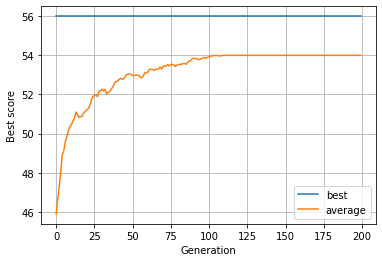

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(best_score_progress)
plt.plot(avg_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score')
plt.legend(['best','average'])
plt.grid()
plt.show()

## Ejercicio 1
Resuelve el problema del viajero del notebook de Simulated Annealing utilizando algoritmos genéticos

In [85]:
import urllib.request
import urllib.parse
import json

api_key='e1c7e6f1aab4487a873722971682469e'

place1 = 'Paseo de Recoletos 14, Madrid, Spain'
place2 = 'Estadio Santiago Bernabeu, Madrid, Spain'
place3 = 'Calle Alcala 200, Madrid, Spain'
place4 = 'Estadio Wanda Metropolitano, Madrid, Spain'
place5 = 'Museo Thyssen, Madrid, Spain'
place6 = 'Parque del Oeste, Madrid, Spain'
place7 = 'Hospital Zendal, Madrid, Spain'

places = [place1,place2,place3,place4,place5,place6,place7]
latitudes = []
longitudes = []

for place in places:
    url = 'https://api.opencagedata.com/geocode/v1/json?q=' + urllib.parse.quote(place) +'&key='+api_key
    #print(url)

    js = urllib.request.urlopen(url).read()
    obj = json.loads(js)
    
    latitudes.append(obj['results'][0]['geometry']['lat'])
    longitudes.append(obj['results'][0]['geometry']['lng'])


In [86]:
places,latitudes,longitudes

(['Paseo de Recoletos 14, Madrid, Spain',
  'Estadio Santiago Bernabeu, Madrid, Spain',
  'Calle Alcala 200, Madrid, Spain',
  'Estadio Wanda Metropolitano, Madrid, Spain',
  'Museo Thyssen, Madrid, Spain',
  'Parque del Oeste, Madrid, Spain',
  'Hospital Zendal, Madrid, Spain'],
 [40.422402,
  40.4530321,
  40.4206967,
  40.436053,
  40.4162159,
  40.4296961,
  40.4834814],
 [-3.6909051,
  -3.6875478,
  -3.6851451,
  -3.5997158,
  -3.6949317,
  -3.7251884,
  -3.6063005])

In [87]:
def distance(lat1,lon1,lat2,lon2):
    
    from math import sin, cos, sqrt, atan2, radians

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance*1000
    

In [89]:
places.append(places[0])
latitudes.append(latitudes[0])
longitudes.append(longitudes[0])

In [90]:
places

['Paseo de Recoletos 14, Madrid, Spain',
 'Estadio Santiago Bernabeu, Madrid, Spain',
 'Calle Alcala 200, Madrid, Spain',
 'Estadio Wanda Metropolitano, Madrid, Spain',
 'Museo Thyssen, Madrid, Spain',
 'Parque del Oeste, Madrid, Spain',
 'Hospital Zendal, Madrid, Spain',
 'Paseo de Recoletos 14, Madrid, Spain']

In [91]:
def dist_tot(sol):

    dT = 0
    for s in range(len(sol)-1):

        dT += distance(latitudes[sol[s]],longitudes[sol[s]],
                 latitudes[sol[s+1]],longitudes[sol[s+1]])

    return 1/dT

In [105]:
def sub2opt(s0):
    s0 = list(s0)
    cut1 = np.random.randint(low=1,high=len(s0)-2)
    cut2 = np.random.randint(low=cut1+1,high=len(s0)-1)

    saux = s0[cut1:cut2+1]
 
    saux.reverse()
    s1 = s0[:cut1]+saux+s0[cut2+1:]

    return s1

In [92]:
def create_starting_population(individuals,chromosome_length):
    population = [np.zeros(chromosome_length).astype(int) for k in range(individuals)]
    L = list(range(chromosome_length))
    for i in range(individuals):
        random.shuffle(L)
        population[i] = L[0:chromosome_length+1]+[L[0]]
        
    return population

In [93]:
population = create_starting_population(10,7)
population

[[0, 1, 6, 4, 3, 5, 2, 0],
 [4, 5, 6, 1, 0, 3, 2, 4],
 [6, 3, 5, 0, 2, 1, 4, 6],
 [0, 4, 3, 5, 6, 2, 1, 0],
 [2, 1, 4, 0, 6, 5, 3, 2],
 [6, 3, 2, 4, 0, 5, 1, 6],
 [5, 2, 6, 4, 3, 1, 0, 5],
 [6, 3, 5, 1, 0, 2, 4, 6],
 [0, 1, 3, 4, 6, 2, 5, 0],
 [2, 0, 3, 6, 1, 4, 5, 2]]

In [94]:
scores = [dist_tot(ind) for ind in population]
scores

[2.23503343530249e-05,
 2.3794929775939152e-05,
 2.6434755180179927e-05,
 2.0764111883541927e-05,
 2.0760359056400563e-05,
 3.4176241076370576e-05,
 2.1620377488718127e-05,
 2.8116992005176083e-05,
 2.1620377488718127e-05,
 3.1242797962176326e-05]

In [96]:
1/3.4176241076370576e-05

29260.09322574094

In [97]:
select_individual_by_tournament(population,scores)

{'p1': [5, 2, 6, 4, 3, 1, 0, 5], 'p2': [4, 5, 6, 1, 0, 3, 2, 4]}

In [98]:
def breed_by_crossover(parent_1, parent_2):

    child_1 = sub2opt(parent_1)
    child_2 = sub2opt(parent_2)
            
    return child_1,child_2

In [103]:
def mutation(individual, N):
    pm = 1/N
    
    if np.random.random() < pm:
        c1 = np.random.randint(low=1,high=N-1)
        c2 = np.random.randint(low=1,high=N-1)
        i1 = individual[c1]
        individual[c1] = individual[c2]
        individual[c2] = i1
    return individual

In [106]:
best_ind = None
best_score = 0

for k in range(10):
    best_score_progress = [] # Tracks progress
    avg_score_progress = []

    maximum_generation = 200
    pop_size = 100
    N=8
    population = create_starting_population(pop_size,7)
    scores = [dist_tot(ind) for ind in population]

    # Now we'll go through the generations of genetic algorithm
    for generation in range(maximum_generation):
        # Create an empty list for new population
        new_population = []

        # Create new popualtion generating two children at a time
        for i in range(int(pop_size/2)):
            parents = select_individual_by_tournament(population, scores)
            parent_1 = parents['p1']
            parent_2 = parents['p2']
            child_1, child_2 = breed_by_crossover(parent_1, parent_2)
            child_1 = mutation(child_1,N)
            child_2 = mutation(child_2,N)
            new_population.append(child_1)
            new_population.append(child_2)

        # Replace the old population with the new one
        population = np.array(new_population)    

        # Score best solution, and add to tracker
        scores = [dist_tot(ind) for ind in population]
        best_sc = np.max(scores)
        
        if best_sc>best_score: 
            best_score = best_sc
            best_ind = population[np.argmax(scores)]
        
        
        
        avg_score = np.mean(scores)
    #     print('Generation',generation)
    #     print ('New score,: %.3f' %best_score)
        best_score_progress.append(best_score)
        avg_score_progress.append(avg_score)

    # GA has completed required generation
    print ('End best score, avg score:', avg_score)


End best score, avg score: 2.5448379724649596e-05
End best score, avg score: 2.51764482859294e-05
End best score, avg score: 2.467480429385172e-05
End best score, avg score: 2.495029658786218e-05
End best score, avg score: 2.5529181685856442e-05
End best score, avg score: 2.52671964869078e-05
End best score, avg score: 2.6276166414340974e-05
End best score, avg score: 2.5988937519463093e-05
End best score, avg score: 2.5145714970588597e-05
End best score, avg score: 2.5643639167422723e-05


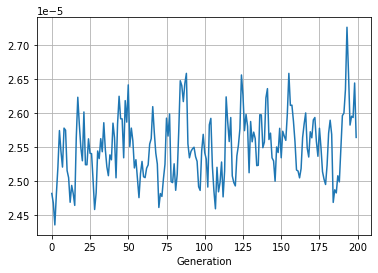

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(avg_score_progress)
plt.xlabel('Generation')

plt.grid()
plt.show()

In [108]:
best_ind

array([4, 5, 1, 6, 3, 2, 0, 4])

In [110]:
1/best_score

28770.78144041276

In [111]:
coord = []
plc = []
for ind in best_ind:
    coord.append([latitudes[ind],longitudes[ind]])
    plc.append(places[ind])
coord,plc

([[40.4162159, -3.6949317],
  [40.4296961, -3.7251884],
  [40.4530321, -3.6875478],
  [40.4834814, -3.6063005],
  [40.436053, -3.5997158],
  [40.4206967, -3.6851451],
  [40.422402, -3.6909051],
  [40.4162159, -3.6949317]],
 ['Museo Thyssen, Madrid, Spain',
  'Parque del Oeste, Madrid, Spain',
  'Estadio Santiago Bernabeu, Madrid, Spain',
  'Hospital Zendal, Madrid, Spain',
  'Estadio Wanda Metropolitano, Madrid, Spain',
  'Calle Alcala 200, Madrid, Spain',
  'Paseo de Recoletos 14, Madrid, Spain',
  'Museo Thyssen, Madrid, Spain'])

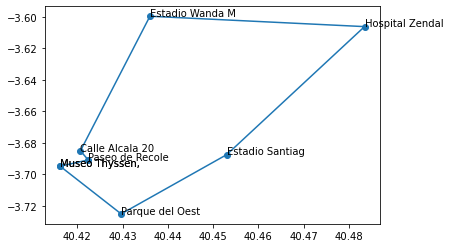

In [112]:
import matplotlib.pyplot as plt

#coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
#coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values


fig, ax = plt.subplots()

#plt.figure()
plt.plot(xs,ys,'o-') 

for i, txt in enumerate(plc):
    ax.annotate(txt[0:15], (xs[i], ys[i]))
    
plt.show() # if you need...

## Ejercicio 2: Resuelve el juego SUMMLE usando algoritmos genéticos

In [8]:
import numpy
import random

In [81]:
serie = [5,6,10,10,12,75]
resultado = 404
ops = ['+','-','*','/']

In [73]:
def generate_ind(serie,sol):
    nsteps=5
    numeros = serie.copy()
    ind = []
    for k in range(5):
        res = -1
        while (res<=0 or not (1.0*res).is_integer()):
            numeros_aux = numeros.copy()
            a = random.choice(numeros_aux)
            numeros_aux.remove(a)

            b = random.choice(numeros_aux)
            numeros_aux.remove(b)

            op = random.choice(ops)
            line = str(a)+op+str(b)

            res = eval(line)

        numeros.remove(a)
        numeros.remove(b)
        ind.append(line)
        numeros.append(res)
        if res ==sol: 
            nsteps = k+1
            return ind,res,nsteps
    return ind,res,nsteps

In [74]:
generate_ind(serie,resultado)

(['5*2', '25+50', '75*3', '225*1', '225+10'], 235, 5)

In [75]:
generate_ind(serie,resultado)

(['50-1', '49*5', '2*25', '3*245', '735-50'], 685, 5)

In [85]:
import time

start_time = time.time()

for k in range(100000):
    ind = generate_ind(serie,resultado)
    if ind[1]==resultado:
        print(ind)
        print(time.time()-start_time)
        
print(time.time()-start_time)

(['75+6', '10/10', '5*81', '405-1.0'], 404.0, 4)
2.6515910625457764
(['5*12', '60/10', '75-6.0', '6.0*69.0', '414.0-10'], 404.0, 5)
4.662488698959351
(['75-10', '10/5', '6*65', '2.0+12', '14.0+390'], 404.0, 5)
10.71080994606018
(['12*5', '75-6', '60/10', '6.0*69', '414.0-10'], 404.0, 5)
12.53997015953064
(['10/10', '75-6', '12+69', '81*5', '405-1.0'], 404.0, 5)
16.45510244369507
(['10/5', '2.0+12', '75-10', '65*6', '14.0+390'], 404.0, 5)
19.063453674316406
(['75-6', '12+69', '10/10', '5*81', '405-1.0'], 404.0, 5)
22.21039128303528
23.79365038871765
